## Introdução


[Árvore de Decisão](#arvore)


[Rede Neural](#redeneural)

[Rede Neural Convolucional](#cnn)

[VGG16 E MLP](#vggmlp)

In [ ]:
#imports
import numpy as np
from sklearn import tree,cluster
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV,train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.layers import Activation, Dense,Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization,UpSampling2D
from tensorflow.keras import Sequential,backend as bk
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD
!pip install keras-tuner --upgrade
import keras_tuner as kt
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing import image
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os,gc
!pip install opencv-python==4.5.5.64 opencv-contrib-python==4.5.5.64 --user
import cv2 as cv
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

data_size, px,py,rgb  = x_train.shape
x_train_tree = x_train.reshape((data_size,px*py*rgb))
data_size, px,py,rgb  = x_test.shape
x_test_tree = x_test.reshape((data_size,px*py*rgb))
y_train_tree = y_train
y_test_tree = y_test

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.20, random_state=42)

x_train_vgg=x_train
x_test_vgg=x_test
x_val_vgg=x_val

x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0

data_size, px,py,rgb  = x_train.shape
x_train_neural = x_train.reshape((data_size,px*py*rgb))
data_size, px,py,rgb  = x_test.shape
x_test2 = x_test.reshape((data_size,px*py*rgb))
data_size, px,py,rgb  = x_val.shape
x_val2 = x_val.reshape((data_size,px*py*rgb))

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

<a name="arvore"></a>
## Árvore de Decisão

### Árvore de decisão com BoF

In [ ]:
sift = cv.SIFT_create()
def extract(x_tree,num_params):
  """Creates the bag of feature trainer
"""
  bof = cv.BOWKMeansTrainer(num_params)
  for img in x_tree:
      img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
      gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
      kp, des = sift.detectAndCompute(gray,None)
      if des is not None:
          bof.add(des)
  return bof

def get_bag(x_set,num_params,bof_dicti):
  """Gets a bag of features for a certain dataset with a certain number of parameters
"""
  bags = []
  for img in x_set.astype('float32'):
      img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
      gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
      bof = np.ravel(bof_dicti.compute(gray,sift.detect(gray)))
      if (len(bof) < num_params):
          bof = np.zeros(num_params)
      bags.append(bof)

  return np.array(bags)

def get_bags(x_train,x_test,num_params):
  """Auxiliar function to get both train and test bags
"""
  bof = extract(x_train,num_params)
  dicti = bof.cluster()
  bof_dicti = cv.BOWImgDescriptorExtractor(sift,cv.BFMatcher(cv.NORM_L2))
  bof_dicti.setVocabulary(dicti)
  train_bags = get_bag(x_train,num_params,bof_dicti)
  test_bags = get_bag(x_test,num_params,bof_dicti)
  return train_bags,test_bags

In [ ]:
num_params = 100
train_bags,test_bags = get_bags(np.concatenate((x_train,x_val)),x_test,num_params)

In [ ]:
def decision_tree_bag():
  """Uses Sklearn Decision Tree to classify the bag of features
"""
  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(train_bags, to_categorical(np.concatenate((y_train,y_val)), 10))
  y_pred_tree=clf.predict(test_bags)
  scr = (classification_report(np.argmax(y_pred_tree, axis=1),y_test))
  cm = (confusion_matrix(np.argmax(y_pred_tree, axis=1),y_test))
  return cm,scr
confmatrix,sc = decision_tree_bag()

              precision    recall  f1-score   support

           0       0.27      0.26      0.26      1059
           1       0.18      0.18      0.18      1013
           2       0.14      0.14      0.14      1006
           3       0.12      0.12      0.12       988
           4       0.10      0.11      0.10       948
           5       0.15      0.15      0.15      1025
           6       0.15      0.15      0.15      1011
           7       0.17      0.16      0.16      1003
           8       0.21      0.22      0.21       958
           9       0.16      0.16      0.16       989

    accuracy                           0.16     10000
   macro avg       0.16      0.16      0.16     10000
weighted avg       0.17      0.16      0.16     10000



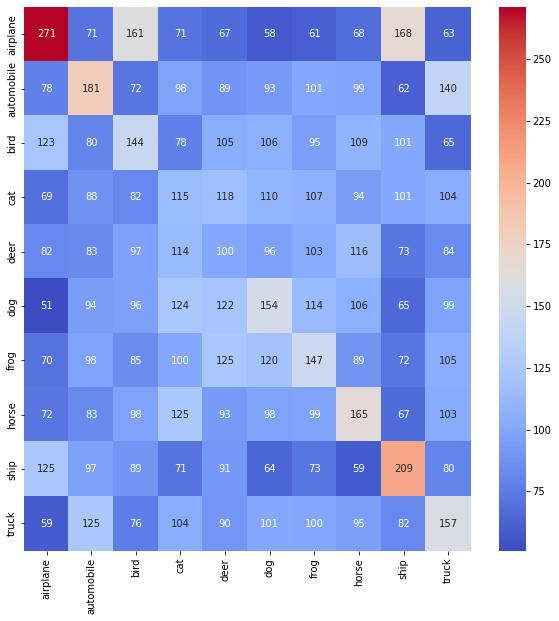

In [ ]:
print(sc)
df_cm = pd.DataFrame(confmatrix, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True,fmt='g',cmap="coolwarm")

### Árvore de decisão sem BoF

In [ ]:
def decision_tree():
  """Classifies the dataset with Sklearn Decision Tree, without bag of features
"""
  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(x_train_tree, y_train_tree)
  y_pred_tree=clf.predict(x_test_tree)
  scr = (classification_report(y_pred_tree,y_test))
  cm = (confusion_matrix(y_pred_tree,y_test))
  return cm,scr
confmatrix,sc = decision_tree()
del x_train_tree,x_test_tree,y_train_tree

              precision    recall  f1-score   support

           0       0.36      0.34      0.35      1066
           1       0.26      0.29      0.27       923
           2       0.22      0.21      0.21      1063
           3       0.18      0.18      0.18       985
           4       0.22      0.22      0.22      1021
           5       0.21      0.22      0.21       971
           6       0.28      0.29      0.28       982
           7       0.27      0.27      0.27       989
           8       0.38      0.36      0.37      1033
           9       0.29      0.30      0.29       967

    accuracy                           0.27     10000
   macro avg       0.27      0.27      0.27     10000
weighted avg       0.27      0.27      0.27     10000



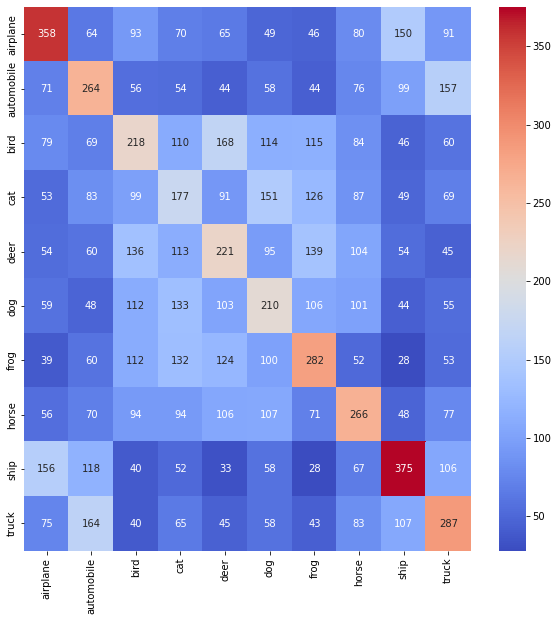

In [ ]:
print(sc)
df_cm = pd.DataFrame(confmatrix, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True,fmt='g',cmap="coolwarm")

#### Código dos Testes

In [ ]:
#Tree
param={"criterion":['gini','entropy'],"splitter":["best","random"]}
dec_tree= tree.DecisionTreeClassifier()
grid = GridSearchCV(dec_tree,param_grid=param,scoring='accuracy',return_train_score=True, verbose=10)
grid.fit(x_train_neural,y_train)
print(grid.best_estimator_)

<a name="redeneural"></a>
## Rede Neural

In [ ]:
def train_neural():
  """Creates a neural network model and evaluates the testing dataset
"""
  X_train_neural = np.concatenate((x_train_neural, x_val2)).astype('float32')
  X_test_rede = x_test2.astype('float32')
  nclasses = 10
  Y_train_neural = to_categorical(np.concatenate((y_train,y_val)), nclasses)
  Y_test_rede = to_categorical(y_test, nclasses)

  model = Sequential()
  model.add(Dense(512, input_shape=(px*py*rgb,)))
  model.add(Activation('relu'))
  model.add(Dense(384, input_shape=(px*py*rgb,)))
  model.add(Activation('relu'))
  model.add(Dense(512, input_shape=(px*py*rgb,)))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  sgd = SGD(learning_rate=0.1)
  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

  batch_size = 64
  nb_epoch = 18
  model.fit(X_train_neural, Y_train_neural,
  batch_size=batch_size, epochs=nb_epoch,
  verbose=1,
  validation_split = 0.2)

  score = model.evaluate(X_test_rede, Y_test_rede, verbose=0)

  y_pred_rede=model.predict(X_test_rede)
  y_pred_rede=np.argmax(y_pred_rede, axis=1)
  Y_test_rede=np.argmax(Y_test_rede, axis=1)
  cm = confusion_matrix(Y_test_rede, y_pred_rede)
  return cm,score[1]

confmatrix,sc = train_neural()
del x_train_neural,x_test2,x_val2

Epoch 1/18
625/625 [==============================] - 5s 4ms/step - loss: 1.9509 - accuracy: 0.2904 - val_loss: 1.8708 - val_accuracy: 0.3196
Epoch 2/18
625/625 [==============================] - 2s 4ms/step - loss: 1.7423 - accuracy: 0.3772 - val_loss: 1.6374 - val_accuracy: 0.4135
Epoch 3/18
625/625 [==============================] - 2s 4ms/step - loss: 1.6444 - accuracy: 0.4078 - val_loss: 1.6393 - val_accuracy: 0.4097
Epoch 4/18
625/625 [==============================] - 2s 3ms/step - loss: 1.5731 - accuracy: 0.4361 - val_loss: 1.5290 - val_accuracy: 0.4560
Epoch 5/18
625/625 [==============================] - 2s 4ms/step - loss: 1.5145 - accuracy: 0.4600 - val_loss: 1.5384 - val_accuracy: 0.4534
Epoch 6/18
625/625 [==============================] - 2s 4ms/step - loss: 1.4681 - accuracy: 0.4736 - val_loss: 1.4807 - val_accuracy: 0.4681
Epoch 7/18
625/625 [==============================] - 2s 4ms/step - loss: 1.4256 - accuracy: 0.4881 - val_loss: 1.4812 - val_accuracy: 0.4746
Epoch 

0.4952000081539154


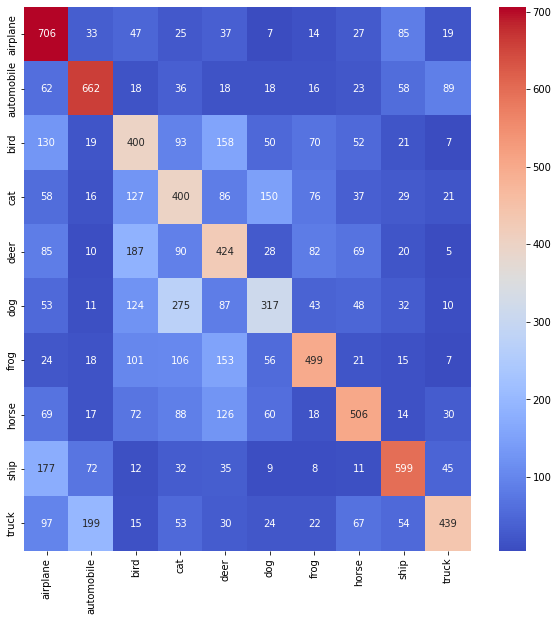

In [ ]:
print(sc)
df_cm = pd.DataFrame(confmatrix, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True,fmt='g',cmap="coolwarm")

### Código dos Testes

In [ ]:
X_train_neural = x_train_neural.astype('float32')
X_val_rede = x_val2.astype('float32')
X_test_rede = x_test2.astype('float32')
nclasses = 10
Y_train_neural = to_categorical(y_train, nclasses)
Y_val_rede = to_categorical(y_val,nclasses)
Y_test_rede = to_categorical(y_test, nclasses)

def train_neural(hp):
  model = Sequential()
  model.add(Dense(units=hp.Int('dense1', min_value=32, max_value=512, step=32)))
  model.add(Activation('relu'))
  if hp.Boolean("denseadd2"):
    model.add(Dense(units=hp.Int('dense2', min_value=32, max_value=512, step=32)))
    model.add(Activation('relu'))
  if hp.Boolean("denseadd3"):
    model.add(Dense(units=hp.Int('dense3', min_value=32, max_value=512, step=32)))
    model.add(Activation('relu'))
  model.add(Dense(10,activation='softmax'))

  lr = hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3])
  sgd = SGD(learning_rate=lr)
  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

  return model

tuner = kt.tuners.BayesianOptimization(
  train_neural,
  objective='val_loss',
  max_trials=100)

tuner.search(X_train_neural, Y_train_neural, epochs=10, validation_data=(X_val_rede,Y_val_rede))
for h_param in [f"dense{i}" for i in range(1,4)] + ['learning_rate'] + [f"denseadd{i}" for i in range(2,4)]:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))
#dense1 512
#dense2 384
#dense3 512
#learning_rate 0.1
#denseadd2 True
#denseadd3 True

In [ ]:
def train_neural(param):
  X_train_neural = x_train_neural.astype('float32')
  X_val_rede = x_val2.astype('float32')
  X_test_rede = x_test2.astype('float32')
  nclasses = 10
  Y_train_neural = to_categorical(y_train, nclasses)
  Y_val_rede = to_categorical(y_val,nclasses)
  Y_test_rede = to_categorical(y_test, nclasses)

  model = Sequential()
  model.add(Dense(512, input_shape=(px*py*rgb,)))
  model.add(Activation('relu'))
  model.add(Dense(384, input_shape=(px*py*rgb,)))
  model.add(Activation('relu'))
  model.add(Dense(512, input_shape=(px*py*rgb,)))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  sgd = SGD(learning_rate=0.1)
  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])


  batch_size = param
  nb_epoch = 10
  model.fit(X_train_neural, Y_train_neural,
  batch_size=batch_size, epochs=nb_epoch,
  verbose=1,
  validation_data=(X_val_rede, Y_val_rede))

train_neural(1)
train_neural(10)
train_neural(16)
train_neural(32)
train_neural(64)
train_neural(256)
train_neural(512)

#Result = 64. Best val loss and val accuracy

In [ ]:
def train_neural():
  X_train_neural = x_train_neural.astype('float32')
  X_val_rede = x_val2.astype('float32')
  X_test_rede = x_test2.astype('float32')
  nclasses = 10
  Y_train_neural = to_categorical(y_train, nclasses)
  Y_val_rede = to_categorical(y_val,nclasses)
  Y_test_rede = to_categorical(y_test, nclasses)

  model = Sequential()
  model.add(Dense(512, input_shape=(px*py*rgb,)))
  model.add(Activation('relu'))
  model.add(Dense(384, input_shape=(px*py*rgb,)))
  model.add(Activation('relu'))
  model.add(Dense(512, input_shape=(px*py*rgb,)))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  sgd = SGD(learning_rate=0.1)
  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

  earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 5,
                                        restore_best_weights = True)

  batch_size = 64
  nb_epoch = 1000
  model.fit(X_train_neural, Y_train_neural,
  batch_size=batch_size, epochs=nb_epoch,
  verbose=1,
  validation_data=(X_val_rede, Y_val_rede),callbacks=[earlystopping])
train_neural()
#result = 16

<a name="cnn"></a>
## Rede Neural Convolucional

In [ ]:
def train_neuralconvolutional():
  """Creates a Convolutional Neural Network model and evaluates the testing dataset
"""
  X_train_neural = np.concatenate((x_train,x_val))
  X_test_rede = x_test
  nclasses = 10
  Y_train_neural = to_categorical(np.concatenate((y_train,y_val)), nclasses)
  Y_test_rede = to_categorical(y_test, nclasses)

  model = Sequential()
  model.add(Conv2D(filters = 192,kernel_size=11,padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=2, padding='same', strides=2))

  model.add(Conv2D(filters = 256,kernel_size=5,padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2, padding='same', strides=2))

  model.add(Conv2D(filters = 416,kernel_size=3,padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters = 384,kernel_size=3,padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(filters = 288,kernel_size=3,padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=2,padding='same', strides=2))
  model.add(Flatten())

  model.add(Dense(8912))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(5120))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  sgd = SGD(learning_rate=0.001)
  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
  batch_size = 10
  nb_epoch = 17

  model.fit(X_train_neural, Y_train_neural,
  batch_size=batch_size, epochs=nb_epoch,
  verbose=1,
  validation_split=0.2)

  score = model.evaluate(X_test_rede, Y_test_rede, verbose=0)
  y_pred_rede=model.predict(X_test_rede)
  y_pred_rede=np.argmax(y_pred_rede, axis=1)
  Y_test_rede=np.argmax(Y_test_rede, axis=1)
  cm = confusion_matrix(Y_test_rede, y_pred_rede)
  return cm,score[1]

confmatrix,sc = train_neuralconvolutional()
del x_train,x_val,x_test

Epoch 1/17
4000/4000 [==============================] - 108s 24ms/step - loss: 2.6969 - accuracy: 0.2515 - val_loss: 1.9360 - val_accuracy: 0.3690
Epoch 2/17
4000/4000 [==============================] - 98s 25ms/step - loss: 2.0308 - accuracy: 0.3552 - val_loss: 1.6577 - val_accuracy: 0.4512
Epoch 3/17
4000/4000 [==============================] - 95s 24ms/step - loss: 1.7704 - accuracy: 0.4141 - val_loss: 1.4562 - val_accuracy: 0.4981
Epoch 4/17
4000/4000 [==============================] - 98s 25ms/step - loss: 1.5934 - accuracy: 0.4615 - val_loss: 1.5628 - val_accuracy: 0.4717
Epoch 5/17
4000/4000 [==============================] - 95s 24ms/step - loss: 1.4711 - accuracy: 0.4958 - val_loss: 1.3685 - val_accuracy: 0.5386
Epoch 6/17
4000/4000 [==============================] - 98s 24ms/step - loss: 1.3644 - accuracy: 0.5348 - val_loss: 1.4151 - val_accuracy: 0.5321
Epoch 7/17
4000/4000 [==============================] - 99s 25ms/step - loss: 1.2765 - accuracy: 0.5614 - val_loss: 1.2868 

0.6875


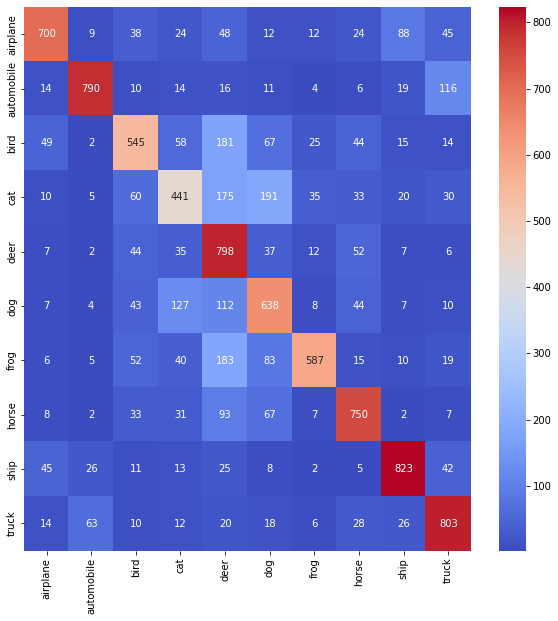

In [ ]:
print(sc)
df_cm = pd.DataFrame(confmatrix, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True,fmt='g',cmap="coolwarm")

### Código dos Testes

In [ ]:
X_train_neural = x_train
X_val_rede = x_val
X_test_rede = x_test
nclasses = 10
Y_train_neural = to_categorical(y_train, nclasses)
Y_val_rede = to_categorical(y_val,nclasses)
Y_test_rede = to_categorical(y_test, nclasses)

def train_neuralconvolutional(hp):
  model = Sequential()
  model.add(Conv2D(filters = hp.Int(name='convolucao1',
                                                      min_value=96,
                                                       max_value=256,
                                                       default=96,
                                                       step=32),
                                      kernel_size=11, strides=4, padding='same'))
  model.add(Activation('relu'))
  if hp.Boolean("BN1"):
      model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2, padding='same', strides=2))
  model.add(Conv2D(filters = hp.Int(name='convolucao2',
                                                       min_value=256,
                                                       max_value=512,
                                                       default=256,
                                                       step=32),
                                      kernel_size=5, padding='same'))
  model.add(Activation('relu'))
  if hp.Boolean("BN2"):
      model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2, padding='same', strides=2))

  model.add(Conv2D(filters = hp.Int(name='convolucao3',
                                                       min_value=384,
                                                       max_value=512,
                                                       default=384,
                                                       step=32),
                                      kernel_size=3, padding='same'))
  model.add(Activation('relu'))
  if hp.Boolean("BN3"):
      model.add(BatchNormalization())
  model.add(Conv2D(filters = hp.Int(name='convolucao4',
                                                       min_value=384,
                                                       max_value=512,
                                                       default=384,
                                                       step=32),
                                      kernel_size=3, padding='same'))
  model.add(Activation('relu'))
  if hp.Boolean("BN4"):
      model.add(BatchNormalization())
  model.add(Conv2D(filters = hp.Int(name='convolucao5',
                                                       min_value=256,
                                                       max_value=512,
                                                       default=256,
                                                       step=32),
                                      kernel_size=3, padding='same'))
  model.add(Activation('relu'))
  if hp.Boolean("BN5"):
      model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2,padding='same', strides=2))
  model.add(Flatten())

  model.add(Dense(units = hp.Int(name='dense1',
                                                  min_value=4096,
                                                  max_value=8192,
                                                  default=4096,
                                                  step=256)))
  model.add(Activation('relu'))
  if hp.Boolean("BN6"):
      model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout_1', 0, 0.5, step=0.1, default=0.5)))
  model.add(Dense(units = hp.Int(name='dense2',
                                                   min_value=4096,
                                                    max_value=8192,
                                                    default=4096,
                                                    step=256)))
  model.add(Activation('relu'))
  if hp.Boolean("BN7"):
      model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout_2', 0, 0.5, step=0.1, default=0.5)))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  lr = hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3])
  sgd = SGD(learning_rate=lr)
  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
  return model


tuner = kt.tuners.BayesianOptimization(
  train_neuralconvolutional,
  objective='val_loss',
  max_trials=100
)

tuner.search(X_train_neural, Y_train_neural, epochs=10, validation_data=(X_val_rede,Y_val_rede))
for h_param in [f"convolucao{i}" for i in range(1,6)] + [f"dense{i}" for i in range(1,3)] +[f"dropout_{i}" for i in range(1,3)] + [f"BN{i}" for i in range(1,8)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

#convolucao1 192
#convolucao2 256
#convolucao3 416
#convolucao4 384
#convolucao5 288
#dense1 8192
#dense2 5120
#dropout_1 0.5
#dropout_2 0.5
#BN1 False
#BN2 True
#BN3 True
#BN4 False
#BN5 False
#BN6 True
#BN7 True
#learning_rate 0.001

In [ ]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        bk.clear_session()

def train_neuralconvolutional(param):
  X_train_neural = x_train
  X_val_rede = x_val
  X_test_rede = x_test
  nclasses = 10
  Y_train_neural = to_categorical(y_train, nclasses)
  Y_val_rede = to_categorical(y_val,nclasses)
  Y_test_rede = to_categorical(y_test, nclasses)
  model = Sequential()
  model.add(Conv2D(filters = 192,kernel_size=11,padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=2, padding='same', strides=2))

  model.add(Conv2D(filters = 256,kernel_size=5,padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2, padding='same', strides=2))

  model.add(Conv2D(filters = 416,kernel_size=3,padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters = 384,kernel_size=3,padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(filters = 288,kernel_size=3,padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=2,padding='same', strides=2))
  model.add(Flatten())

  model.add(Dense(8912))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(5120))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  sgd = SGD(learning_rate=0.001)
  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
  batch_size = param
  nb_epoch = 10

  model.fit(X_train_neural, Y_train_neural,
  batch_size=batch_size, epochs=nb_epoch,
  verbose=1,
  validation_data=(X_val_rede, Y_val_rede),callbacks=[ClearMemory()])

train_neuralconvolutional(10)
train_neuralconvolutional(32)
train_neuralconvolutional(64)
train_neuralconvolutional(100)
train_neuralconvolutional(256)
#result = 10

In [ ]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        bk.clear_session()

def train_neuralconvolutional():
  X_train_neural = x_train
  X_val_rede = x_val
  X_test_rede = x_test
  nclasses = 10
  Y_train_neural = to_categorical(y_train, nclasses)
  Y_val_rede = to_categorical(y_val,nclasses)
  Y_test_rede = to_categorical(y_test, nclasses)

  model = Sequential()
  model.add(Conv2D(filters = 192,kernel_size=11,padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=2, padding='same', strides=2))

  model.add(Conv2D(filters = 256,kernel_size=5,padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2, padding='same', strides=2))

  model.add(Conv2D(filters = 416,kernel_size=3,padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters = 384,kernel_size=3,padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(filters = 288,kernel_size=3,padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=2,padding='same', strides=2))
  model.add(Flatten())

  model.add(Dense(8912))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(5120))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  sgd = SGD(learning_rate=0.001)
  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
  earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 5,
                                        restore_best_weights = True)
  batch_size = 10
  nb_epoch = 200

  model.fit(X_train_neural, Y_train_neural,
  batch_size=batch_size, epochs=nb_epoch,
  verbose=1,
  validation_data=(X_val_rede, Y_val_rede),callbacks=[ClearMemory(),earlystopping])

train_neuralconvolutional()
#result = 17

<a name="vggmlp"></a>
## VGG16 e MLP

In [ ]:
def Extract_VGG16(x_train_e,x_val_e,x_test_e):
  """Preprocesses the dataset and extracts features trained with VGG16 and imagenet
"""
  x_train_e = preprocess_input(np.concatenate((x_train_e,x_val_e)).astype('float32'))
  x_test_e = preprocess_input(x_test_e.astype('float32'))
  model = Sequential()
  model.add(UpSampling2D())
  model.add(VGG16(weights='imagenet', include_top=False,pooling='avg'))
  return model.predict(x_train_e),model.predict(x_test_e)

def MLP():
  """Creates the MLP model to use with the VGG16 extracted features
"""
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(768, activation=('relu')))
  model.add(Dropout(0.5))
  model.add(Dense(416, activation=('relu')))
  model.add(Dropout(0.2))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  sgd = SGD(learning_rate=0.01)

  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

  nclasses = 10
  Y_train_neural = to_categorical(np.concatenate((y_train,y_val)),nclasses)
  Y_test_rede = to_categorical(y_test,nclasses)
  batch_size = 16
  nb_epoch = 18
  model.fit(X_train_features, Y_train_neural,
  batch_size=batch_size, epochs=nb_epoch,
  verbose=1,
  validation_split = 0.2)

  score = model.evaluate(X_test_features, Y_test_rede, verbose=0)

  y_pred_rede=model.predict(X_test_features)
  y_pred_rede=np.argmax(y_pred_rede, axis=1)
  Y_test_rede=np.argmax(Y_test_rede, axis=1)
  cm = confusion_matrix(Y_test_rede, y_pred_rede)
  return cm,score[1]

X_train_features,X_test_features = Extract_VGG16(x_train_vgg,x_val_vgg,x_test_vgg)

confmatrix,sc = MLP()

58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/18
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2486 - accuracy: 0.6422 - val_loss: 0.8115 - val_accuracy: 0.7428
Epoch 2/18
2500/2500 [==============================] - 7s 3ms/step - loss: 0.8181 - accuracy: 0.7240 - val_loss: 0.7264 - val_accuracy: 0.7737
Epoch 3/18
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7401 - accuracy: 0.7498 - val_loss: 0.7006 - val_accuracy: 0.7736
Epoch 4/18
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6743 - accuracy: 0.7732 - val_loss: 0.6658 - val_accuracy: 0.7910
Epoch 5/18
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6387 - accuracy: 0.7821 - val_loss: 0.6469 - val_accuracy: 0.7873
Epoch 6/18
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6043 - accuracy: 0.7921 - val_loss: 0.6083 - val_accuracy: 0.8018
Epoch 7/18
2500/2500 [==============================] - 7s 3ms/step - l

0.8095999956130981


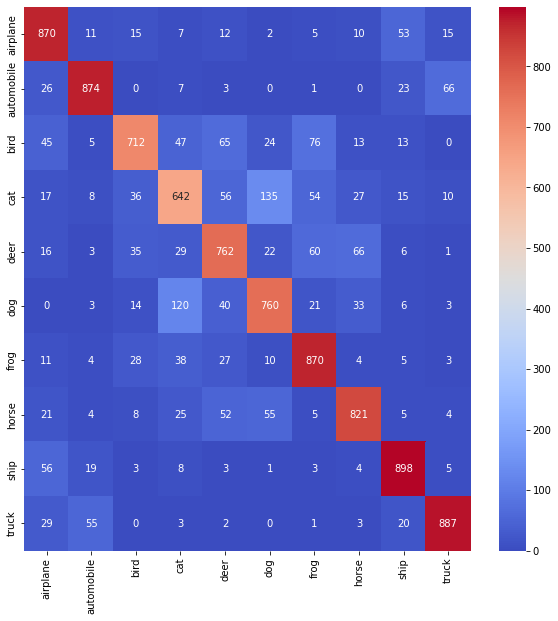

In [ ]:
print(sc)
df_cm = pd.DataFrame(confmatrix, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True,fmt='g',cmap="coolwarm")

### Código dos Testes

In [ ]:
def Extract_VGG16(x_train_e,x_val_e,x_test_e):
  x_train_e = preprocess_input(x_train_e.astype('float32'))
  x_val_e = preprocess_input(x_val_e.astype('float32'))
  x_test_e = preprocess_input(x_test_e.astype('float32'))
  model = Sequential()
  model.add(UpSampling2D())
  model.add(VGG16(weights='imagenet', include_top=False,pooling='avg'))
  return model.predict(x_train_e),model.predict(x_val_e),model.predict(x_test_e)

X_train_features,X_val_features,X_test_features = Extract_VGG16(x_train_vgg,x_val_vgg,x_test_vgg)

def MLP(hp):
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(units = hp.Int(name='dense1',min_value=256,max_value=9216,default=256,step=32)))
  model.add(Activation('relu'))
  model.add(Dropout(hp.Float('dropout_1', 0, 0.5, step=0.1, default=0.5)))

  if hp.Boolean("denseadd1"):
    model.add(Dense(units=hp.Int('dense2', min_value=32, max_value=4608, step=32)))
    model.add(Activation('relu'))
    model.add(Dropout(hp.Float('dropout_2', 0, 0.5, step=0.1, default=0.5)))

  if hp.Boolean("denseadd2"):
      model.add(Dense(units = hp.Int(name='dense3',min_value=32,max_value=4608,default=32,step=32)))
      model.add(Activation('relu'))
      model.add(Dropout(hp.Float('dropout_3', 0, 0.5, step=0.1, default=0.5)))

  if hp.Boolean("denseadd3"):
      model.add(Dense(units = hp.Int(name='dense4',min_value=32,max_value=4608,default=32,step=32)))
      model.add(Activation('relu'))
      model.add(Dropout(hp.Float('dropout_4', 0, 0.5, step=0.1, default=0.5)))

  model.add(Dense(10))
  model.add(Activation('softmax'))
  lr = hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3])
  sgd = SGD(learning_rate=lr)
  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
  return model


nclasses = 10
Y_train_neural = to_categorical(y_train, nclasses)
Y_val_rede = to_categorical(y_val,nclasses)
Y_test_rede = to_categorical(y_test, nclasses)

tuner = kt.tuners.BayesianOptimization(
    MLP,
    objective='val_loss',
    max_trials=100
)
tuner.search(X_train_features, Y_train_neural, epochs=10, validation_data=(X_val_features,Y_val_rede))
for h_param in [f"dense{i}" for i in range(1,5)] +[f"dropout_{i}" for i in range(1,5)] + [f"denseadd{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))
#dense1 768
#dense2 416
#dense3 96
#dense4 192
#dropout_1 0.5
#dropout_2 0.2
#dropout_3 0.5
#dropout_4 0.30000000000000004
#denseadd1 True
#denseadd2 False
#denseadd3 False
#learning_rate 0.01

In [ ]:
def Extract_VGG16(x_train_e,x_val_e,x_test_e):
  x_train_e = preprocess_input(x_train_e.astype('float32'))
  x_val_e = preprocess_input(x_val_e.astype('float32'))
  x_test_e = preprocess_input(x_test_e.astype('float32'))
  model = Sequential()
  model.add(UpSampling2D())
  model.add(VGG16(weights='imagenet', include_top=False,pooling='avg'))
  return model.predict(x_train_e),model.predict(x_val_e),model.predict(x_test_e)

def MLP(param):
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(768, activation=('relu')))
  model.add(Dropout(0.5))
  model.add(Dense(416, activation=('relu')))
  model.add(Dropout(0.2))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  sgd = SGD(learning_rate=0.01)
  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
  nclasses = 10
  Y_train_neural = to_categorical(y_train, nclasses)
  Y_val_rede = to_categorical(y_val,nclasses)
  batch_size = param
  nb_epoch = 10
  model.fit(X_train_features, Y_train_neural,
  batch_size=batch_size, epochs=nb_epoch,
  verbose=1,
  validation_data=(X_val_features, Y_val_rede))

X_train_features,X_val_features,X_test_features = Extract_VGG16(x_train_vgg,x_val_vgg,x_test_vgg)
MLP(10)
MLP(16)
MLP(32)
MLP(64)
MLP(256)
MLP(512)
#result=16 best val loss and val accuracy

In [ ]:
def Extract_VGG16(x_train_e,x_val_e,x_test_e):
  x_train_e = preprocess_input(x_train_e.astype('float32'))
  x_val_e = preprocess_input(x_val_e.astype('float32'))
  x_test_e = preprocess_input(x_test_e.astype('float32'))
  model = Sequential()
  model.add(UpSampling2D())
  model.add(VGG16(weights='imagenet', include_top=False,pooling='avg'))
  return model.predict(x_train_e),model.predict(x_val_e),model.predict(x_test_e)

X_train_features,X_val_features,X_test_features = Extract_VGG16(x_train_vgg,x_val_vgg,x_test_vgg)

def MLP():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(768, activation=('relu')))
  model.add(Dropout(0.5))
  model.add(Dense(416, activation=('relu')))
  model.add(Dropout(0.2))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 5,
                                        restore_best_weights = True)

  sgd = SGD(learning_rate=0.01)
  model.compile(loss=
  'categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

  nclasses = 10
  Y_train_neural = to_categorical(y_train, nclasses)
  Y_val_rede = to_categorical(y_val,nclasses)
  batch_size = 16
  nb_epoch = 1000
  model.fit(X_train_features, Y_train_neural,
  batch_size=batch_size, epochs=nb_epoch,
  verbose=1,
  validation_data=(X_val_features, Y_val_rede),callbacks=[earlystopping])


MLP()
#result = 18